 # Gradient Boosting Machines (GBMs) with XGBoost

This tutorial is a part of [Machine Learning with Python: Zero to GBMs](https://zerotogbms.com) and [Zero to Data Science Bootcamp by Jovian](https://zerotodatascience.com)

![](https://i.imgur.com/6MYc56a.png)

The following topics are covered in this tutorial:

- Downloading a real-world dataset from a Kaggle competition
- Performing feature engineering and prepare the dataset for training
- Training and interpreting a gradient boosting model using XGBoost
- Training with KFold cross validation and ensembling results
- Configuring the gradient boosting model and tuning hyperparamters

In [1]:
!pip install numpy pandas matplotlib seaborn 

In [2]:
!pip install jovian xgboost opendatasets graphviz lightgbm scikit-learn --quiet

## Problem Statement

This tutorial takes a practical and coding-focused approach. We'll learn gradient boosting by applying it to a real-world dataset from the [Rossmann Store Sales](https://www.kaggle.com/c/rossmann-store-sales) competition on Kaggle:

> Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. 
>
>
> With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied. You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.
>
> View and download the data here: https://www.kaggle.com/c/rossmann-store-sales/data

## Downloading the Data

We can download the dataset from Kaggle directly within the Jupyter notebook using the `opendatasets` library. Make sure to [accept the competition rules](https://www.kaggle.com/c/rossmann-store-sales/rules) before executing the following cell.

In [5]:
import os
import opendatasets as od
import pandas as pd
pd.set_option("display.max_columns", 120)
pd.set_option("display.max_rows", 120)

In [6]:
od.download('https://www.kaggle.com/competitions/rossmann-store-sales')

Skipping, found downloaded files in "./rossmann-store-sales" (use force=True to force download)


In [8]:
os.listdir('rossmann-store-sales')

['test.csv', 'train.csv', 'store.csv', 'sample_submission.csv']

In [10]:
ross_df = pd.read_csv('./rossmann-store-sales/train.csv', low_memory=False)
store_df = pd.read_csv('./rossmann-store-sales/store.csv')
test_df = pd.read_csv('./rossmann-store-sales/test.csv')
submission_df = pd.read_csv('./rossmann-store-sales/sample_submission.csv')

In [11]:
ross_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


In [12]:
store_df

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [13]:
merged_df = ross_df.merge(store_df, how='left', on='Store')
merged_test_df = test_df.merge(store_df, how='left', on='Store')

In [14]:
merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [15]:
jovian.commit()

<IPython.core.display.Javascript object>

[jovian] Committed successfully! https://jovian.com/pragyakiran03041996/lesson5


'https://jovian.com/pragyakiran03041996/lesson5'

## Preprocessing and Feature Engineering

Let's take a look at the available columns, and figure out if we can create new columns or apply any useful transformations.

In [16]:
def split_date(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['Day'] = df.Date.dt.day
    df['Month'] = df.Date.dt.month
    df['Year'] = df.Date.dt.year
    df['WeekOfYear'] = df.Date.dt.isocalendar().week

In [17]:
split_date(merged_df)
split_date(merged_test_df)

In [18]:
merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Day,Month,Year,WeekOfYear
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,31,7,2015,31
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",31,7,2015,31
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",31,7,2015,31
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,31,7,2015,31
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,31,7,2015,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",1,1,2013,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN,1,1,2013,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN,1,1,2013,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN,1,1,2013,1


### Store Open/Closed

Next, notice that the sales are zero whenever the store is closed.

In [20]:
merged_df[merged_df.Open == 0].Sales.value_counts()

0    172817
Name: Sales, dtype: int64

Instead of trying to model this relationship, it would be better to hard-code it in our predictions, and remove the rows where the store is closed. We won't remove any rows from the test set, since we need to make predictions for every row.

In [21]:
merged_df = merged_df[merged_df.Open == 1].copy()

### Competition

Next, we can use the columns `CompetitionOpenSince[Month/Year]` columns from `store_df` to compute the number of months for which a competitor has been open near the store.

Here, we are using feature engineering to combine two columns `CompetitionOpenSinceYear` and `CompetitionOpenSinceMonth` to create a new column which will tell how long the `CompetitionStore` has been there compared to the day we are looking at

In [25]:
def comp_months(df):
    df['CompetitionOpen'] = 12 * (df.Year - df.CompetitionOpenSinceYear) + (df.Month - df.CompetitionOpenSinceMonth)
    df['CompetitionOpen'] = df['CompetitionOpen'].map(lambda x: 0 if x < 0 else x).fillna(0)
    
# in the last line, we are replacing negative values with zero, this is to make sure that we dont have any 
# information about the competiting stores that are not available (will open in future)

In [26]:
comp_months(merged_df)
comp_months(merged_test_df)

In [30]:
merged_df[['Store','Date', 'CompetitionDistance', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth', 'CompetitionOpen']].sample(20)


,Store,Date,CompetitionDistance,CompetitionOpenSinceYear,CompetitionOpenSinceMonth,CompetitionOpen
297527,445,2014-10-27,240.0,NaN,NaN,0.0
953346,807,2013-02-27,3870.0,2008.0,4.0,58.0
967681,647,2013-02-14,7420.0,2013.0,4.0,0.0
844482,98,2013-06-04,15140.0,2006.0,12.0,78.0
871352,208,2013-05-11,300.0,2006.0,4.0,85.0
649372,113,2013-11-26,20930.0,1999.0,11.0,168.0
710629,45,2013-10-02,9710.0,2014.0,2.0,0.0
953344,805,2013-02-27,24770.0,2011.0,10.0,16.0
582649,290,2014-01-25,4150.0,2001.0,5.0,152.0
507351,812,2014-04-03,2590.0,2012.0,9.0,19.0


In [38]:
merged_df[(merged_df.Date == '2014-11-20') & (merged_df.Store == 918)][['Store', 'Date','CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth', 'CompetitionOpen']]

,Store,Date,CompetitionOpenSinceYear,CompetitionOpenSinceMonth,CompetitionOpen
275479,918,2014-11-20,2015.0,4.0,0.0


So, we see that in this particular row, we are looking at date 2014-11-20 and the competiting store opened in 2015, so for that particular Date, the store is opening in future, so the `CompetitionOpen` column is 0


### Additional Promotion

We can also add some additional columns to indicate how long a store has been running `Promo2` and whether a new round of `Promo2` starts in the current month.

In [41]:
merged_df[['Date', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval','WeekOfYear']].sample(10)

,Date,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,WeekOfYear
1006815,2013-01-10,1,40.0,2011.0,"Jan,Apr,Jul,Oct",2
286156,2014-11-08,0,NaN,NaN,NaN,45
50085,2015-06-17,1,48.0,2012.0,"Mar,Jun,Sept,Dec",25
359687,2014-08-22,1,1.0,2014.0,"Jan,Apr,Jul,Oct",34
463743,2014-05-12,0,NaN,NaN,NaN,20
593293,2014-01-16,1,13.0,2010.0,"Jan,Apr,Jul,Oct",3
620036,2013-12-23,0,NaN,NaN,NaN,52
520525,2014-03-22,0,NaN,NaN,NaN,12
369859,2014-08-11,1,31.0,2013.0,"Jan,Apr,Jul,Oct",33
143148,2015-03-25,1,31.0,2013.0,"Jan,Apr,Jul,Oct",13


In [42]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 0 to 1017190
Data columns (total 23 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      844392 non-null  int64         
 1   DayOfWeek                  844392 non-null  int64         
 2   Date                       844392 non-null  datetime64[ns]
 3   Sales                      844392 non-null  int64         
 4   Customers                  844392 non-null  int64         
 5   Open                       844392 non-null  int64         
 6   Promo                      844392 non-null  int64         
 7   StateHoliday               844392 non-null  object        
 8   SchoolHoliday              844392 non-null  int64         
 9   StoreType                  844392 non-null  object        
 10  Assortment                 844392 non-null  object        
 11  CompetitionDistance        842206 non-null  float64

In [52]:
def check_promo_month(row):
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',              
                 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    try:
        months = (row['PromoInterval'] or '').split(',')
        if row['Promo2Open'] and month2str[row['Month']] in months:
            return 1
        else:
            return 0
    except Exception:
        return 0

def promo_cols(df):
    # Months since Promo2 was open
    df['Promo2Open'] = 12 * (df.Year - df.Promo2SinceYear) +  (df.WeekOfYear - df.Promo2SinceWeek)*7/30.5
    df['Promo2Open'] = df['Promo2Open'].map(lambda x: 0 if x < 0 else x).fillna(0) * df['Promo2']
    
    # Whether a new round of promotions was started in the current month
    df['IsPromo2Month'] = df.apply(check_promo_month, axis=1) * df['Promo2']

In [53]:
promo_cols(merged_df)
promo_cols(merged_test_df)

In [54]:
merged_df[['Date', 'Promo2', 'Promo2SinceYear', 'Promo2SinceWeek', 'PromoInterval', 'Promo2Open', 'IsPromo2Month']].sample(20)

,Date,Promo2,Promo2SinceYear,Promo2SinceWeek,PromoInterval,Promo2Open,IsPromo2Month
863721,2013-05-18,0,NaN,NaN,NaN,0.000000,0
145596,2015-03-23,0,NaN,NaN,NaN,0.000000,0
792432,2013-07-21,0,NaN,NaN,NaN,0.000000,0
828567,2013-06-19,1,2009.0,37.0,"Jan,Apr,Jul,Oct",45.245902,0
853934,2013-05-27,0,NaN,NaN,NaN,0.000000,0
622751,2013-12-20,1,2010.0,5.0,"Feb,May,Aug,Nov",46.557377,0
281215,2014-11-14,1,2012.0,40.0,"Feb,May,Aug,Nov",25.377049,1
172042,2015-02-27,0,NaN,NaN,NaN,0.000000,0
904089,2013-04-12,0,NaN,NaN,NaN,0.000000,0
657086,2013-11-19,1,2012.0,22.0,"Jan,Apr,Jul,Oct",17.737705,0


In [55]:
merged_df['IsPromo2Month'].nunique()

2

The features related to competition and promotion are now much more useful.

In [57]:
merged_df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Day', 'Month', 'Year',
       'WeekOfYear', 'CompetitionOpen', 'Promo2Open', 'IsPromo2Month'],
      dtype='object')

In [58]:
input_cols = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 
              'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpen', 
              'Day', 'Month', 'Year', 'WeekOfYear',  'Promo2', 
              'Promo2Open', 'IsPromo2Month']
target_col = 'Sales'

In [59]:
inputs = merged_df[input_cols].copy()
targets = merged_df[target_col].copy()

In [60]:
test_inputs = merged_test_df[input_cols].copy()

In [61]:
numeric_cols = ['Store', 'Promo', 'SchoolHoliday', 
              'CompetitionDistance', 'CompetitionOpen', 'Promo2', 'Promo2Open', 'IsPromo2Month',
              'Day', 'Month', 'Year', 'WeekOfYear',  ]
categorical_cols = ['DayOfWeek', 'StateHoliday', 'StoreType', 'Assortment']

In [62]:
inputs.head(10)

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpen,Day,Month,Year,WeekOfYear,Promo2,Promo2Open,IsPromo2Month
0,1,5,1,0,1,c,a,1270.0,82.0,31,7,2015,31,0,0.000000,0
1,2,5,1,0,1,a,a,570.0,92.0,31,7,2015,31,1,64.131148,1
2,3,5,1,0,1,a,a,14130.0,103.0,31,7,2015,31,1,51.901639,1
3,4,5,1,0,1,c,c,620.0,70.0,31,7,2015,31,0,0.000000,0
4,5,5,1,0,1,a,a,29910.0,3.0,31,7,2015,31,0,0.000000,0
5,6,5,1,0,1,a,a,310.0,19.0,31,7,2015,31,0,0.000000,0
6,7,5,1,0,1,a,c,24000.0,27.0,31,7,2015,31,0,0.000000,0
7,8,5,1,0,1,a,a,7520.0,9.0,31,7,2015,31,0,0.000000,0
8,9,5,1,0,1,a,c,2030.0,179.0,31,7,2015,31,0,0.000000,0
9,10,5,1,0,1,a,a,3160.0,70.0,31,7,2015,31,0,0.000000,0


### Impute missing numerical data

In [63]:
inputs[numeric_cols].isna().sum()

Store                     0
Promo                     0
SchoolHoliday             0
CompetitionDistance    2186
CompetitionOpen           0
Promo2                    0
Promo2Open                0
IsPromo2Month             0
Day                       0
Month                     0
Year                      0
WeekOfYear                0
dtype: int64

In [64]:
test_inputs[numeric_cols].isna().sum()

Store                   0
Promo                   0
SchoolHoliday           0
CompetitionDistance    96
CompetitionOpen         0
Promo2                  0
Promo2Open              0
IsPromo2Month           0
Day                     0
Month                   0
Year                    0
WeekOfYear              0
dtype: int64

Seems like competition distance is the only missing value, and we can simply fill it with the highest value (to indicate that competition is very far away).

We see that only one of the features have some non-zero value i.e `CompetitionDistance`. Instead of using the imputer, we are filling it with the max distance

In [66]:
max_distance = inputs.CompetitionDistance.max()
max_distance #in meters

75860.0

In [67]:
inputs['CompetitionDistance'].fillna(2.0 * max_distance, inplace=True)
test_inputs['CompetitionDistance'].fillna(2.0 * max_distance, inplace=True)

### Scale Numeric Values

Let's scale numeric values to the 0 to 1 range.

In [68]:
from sklearn.preprocessing import MinMaxScaler

In [69]:
scaler = MinMaxScaler().fit(inputs[numeric_cols])

In [70]:
inputs[numeric_cols] = scaler.transform(inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

### Encode Categorical Columns

<img src="https://i.imgur.com/n8GuiOO.png" width="640">

Let's one-hot encode categorical columns.

In [71]:
from sklearn.preprocessing import OneHotEncoder

In [72]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit(inputs[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))

In [74]:
inputs[encoded_cols] = encoder.transform(inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

Finally, let's extract out all the numeric data for training.

In [75]:
X = inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

We haven't created a validation set yet, because we'll use K-fold cross validation.



In [76]:
jovian.commit()

<IPython.core.display.Javascript object>

[jovian] Updating notebook "pragyakiran03041996/lesson5" on https://jovian.com/
[jovian] Committed successfully! https://jovian.com/pragyakiran03041996/lesson5


'https://jovian.com/pragyakiran03041996/lesson5'

## Gradient Boosting

We're now ready to train our gradient boosting machine (GBM) model. Here's how a GBM model works:

1. The average value of the target column and uses as an initial prediction every input.
2. The residuals (difference) of the predictions with the targets are computed.
3. A decision tree of limited depth is trained to **predict just the residuals** for each input.
4. Predictions from the decision tree are scaled using a parameter called the learning rate (this prevents overfitting)
5. Scaled predictions for the tree are added to the previous predictions to obtain the new and improved predictions.
6. Steps 2 to 5 are repeated to create new decision trees, each of which is trained to predict just the residuals from the previous prediction.

The term "gradient" refers to the fact that each decision tree is trained with the purpose of reducing the loss from the previous iteration (similar to gradient descent). The term "boosting" refers the general technique of training new models to improve the results of an existing model. 

> **EXERCISE**: Can you describe in your own words how a gradient boosting machine is different from a random forest?


For a mathematical explanation of gradient boosting, check out the following resources:

- [XGBoost Documentation](https://xgboost.readthedocs.io/en/latest/tutorials/model.html)
- [Video Tutorials on StatQuest](https://www.youtube.com/watch?v=3CC4N4z3GJc&list=PLblh5JKOoLUJjeXUvUE0maghNuY2_5fY6)

Here's a visual representation of gradient boosting:

![](https://miro.medium.com/max/560/1*85QHtH-49U7ozPpmA5cAaw.png)


Here's how it works:

    1. Start simple: You start with a basic model that makes rough predictions. It could be as simple as guessing the average value for every prediction.

    2. Find mistakes: You figure out where your predictions are wrong. You look at the difference between the predictions and the actual outcomes.

    3. Train a new model to fix mistakes: You bring in a new expert (a weak learner) whose job is to focus on the mistakes made by the previous model. This new expert learns from those mistakes and tries to correct them. "We basically train the DT to make the errors better"

    4. Combine everyone's efforts: You add the predictions from this new expert to the predictions of the previous model, giving more weight to the areas where the previous model went wrong. This combined prediction should be better than any single model alone.

    5. Repeat: You repeat this process, each time bringing in a new expert to focus on the mistakes of the combined team. With each iteration, the team gets better and better at making predictions.

This iterative process continues until the team (ensemble model) is good enough or until you reach a specified number of models.




In gradient boosting, the learning rate is a hyperparameter that controls the contribution of each tree (or weak learner) to the ensemble. It's a crucial parameter because it determines the step size or rate at which we are adjusting the weights of our model with respect to the gradient of the loss function.

Here's how the learning rate works in gradient boosting:

1. **Initial Prediction**: We start with an initial prediction (often the average value for regression or the most common class for classification).

2. **Build a Weak Learner**: We then build a weak learner, usually a decision tree, to predict the residuals (the differences between the actual values and our initial prediction).

3. **Update Prediction**: We update our prediction by adding a fraction of the prediction from this weak learner to our overall prediction. This fraction is the learning rate.

4. **Repeat**: We repeat this process, creating new weak learners to predict the residuals of the previous model and updating our prediction at each step.

The learning rate is a small positive value typically ranging from 0.1 to 0.01. A smaller learning rate means that we take smaller steps in adjusting our predictions, which can result in a more robust model but might require more iterations. Conversely, a larger learning rate means we take larger steps, which might lead to faster convergence but can also result in overshooting the optimal solution.

Tuning the learning rate is essential because it directly affects the training process and the final performance of the gradient boosting model. It's often used in conjunction with other hyperparameters, such as the number of trees, to optimize the model's performance.



Mathematically, prediction is given as 

    \[ P = A + \alpha_i D_i \]
    
    where A is the initial prediction (average)
    and alpha_i is the learning rate
    and D_i is the decision tree which is trained to predict the residuals from the orginal average
        for  i=1, the DT is trained to predict (P-A)
        
        
Learning rate (\alpha) prevents over fitting. A lower learning rate typically leads to slower convergence during training. Slower convergence means the model learns more gradually, adjusting its parameters slowly over time. This can help prevent the model from fitting to the noise in the training data too quickly. If the model is learning too fast (e.g., with a higher learning rate), it might quickly adapt to the noise in the data, leading to overfitting.

## Gradient Boosting Vs Random forest

### Gradient Boosting:
- Builds trees sequentially, with each tree correcting errors of the previous one.
- Sequential training, focusing on difficult-to-predict instances.
- Trees aim to reduce residual errors made by previous trees.
- Higher predictive accuracy, especially with complex data and large datasets.

### Random Forest:
- Constructs trees independently and in parallel.
- Parallel training, each tree is built without knowledge of others.
- Each tree makes its own prediction, and the final prediction is aggregated from all trees.
- Robustness, handles noisy data well, less sensitive to hyperparameters.

### Training

To train a GBM, we can use the `XGBRegressor` class from the [`XGBoost`](https://xgboost.readthedocs.io/en/latest/) library.

In [78]:
from xgboost import XGBRegressor

In [79]:
model = XGBRegressor(random_state = 42, n_jobs=-1, n_estimators=20, max_depth=4)
#n_jobs basically tells the model to use all the thread avaiable for computation

In [80]:
%%time 
model.fit(X, targets)


CPU times: user 2.87 s, sys: 777 ms, total: 3.64 s
Wall time: 567 ms


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=20, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

### Prediction

We can now make predictions and evaluate the model using `model.predict`.

In [81]:
preds = model.predict(X)

In [82]:
preds

array([ 8073.2007,  7278.4395,  8812.854 , ...,  7913.415 ,  7336.718 ,
       10780.133 ], dtype=float32)

### Evaluation

Let's evaluate the predictions using RMSE error.

In [153]:
from sklearn.metrics import root_mean_squared_error

def rmse(a, b):
    return root_mean_squared_error(a, b)

In [85]:
rmse(preds, targets)

/Users/pragya/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


2357.1278101525777

### Visualization

We can visualize individual trees using `plot_tree` (note: this requires the `graphviz` library to be installed).

In [87]:
import matplotlib.pyplot as plt
from xgboost import plot_tree
from matplotlib.pylab import rcParams
%matplotlib inline 

rcParams['figure.figsize'] = 30,30

<AxesSubplot:>

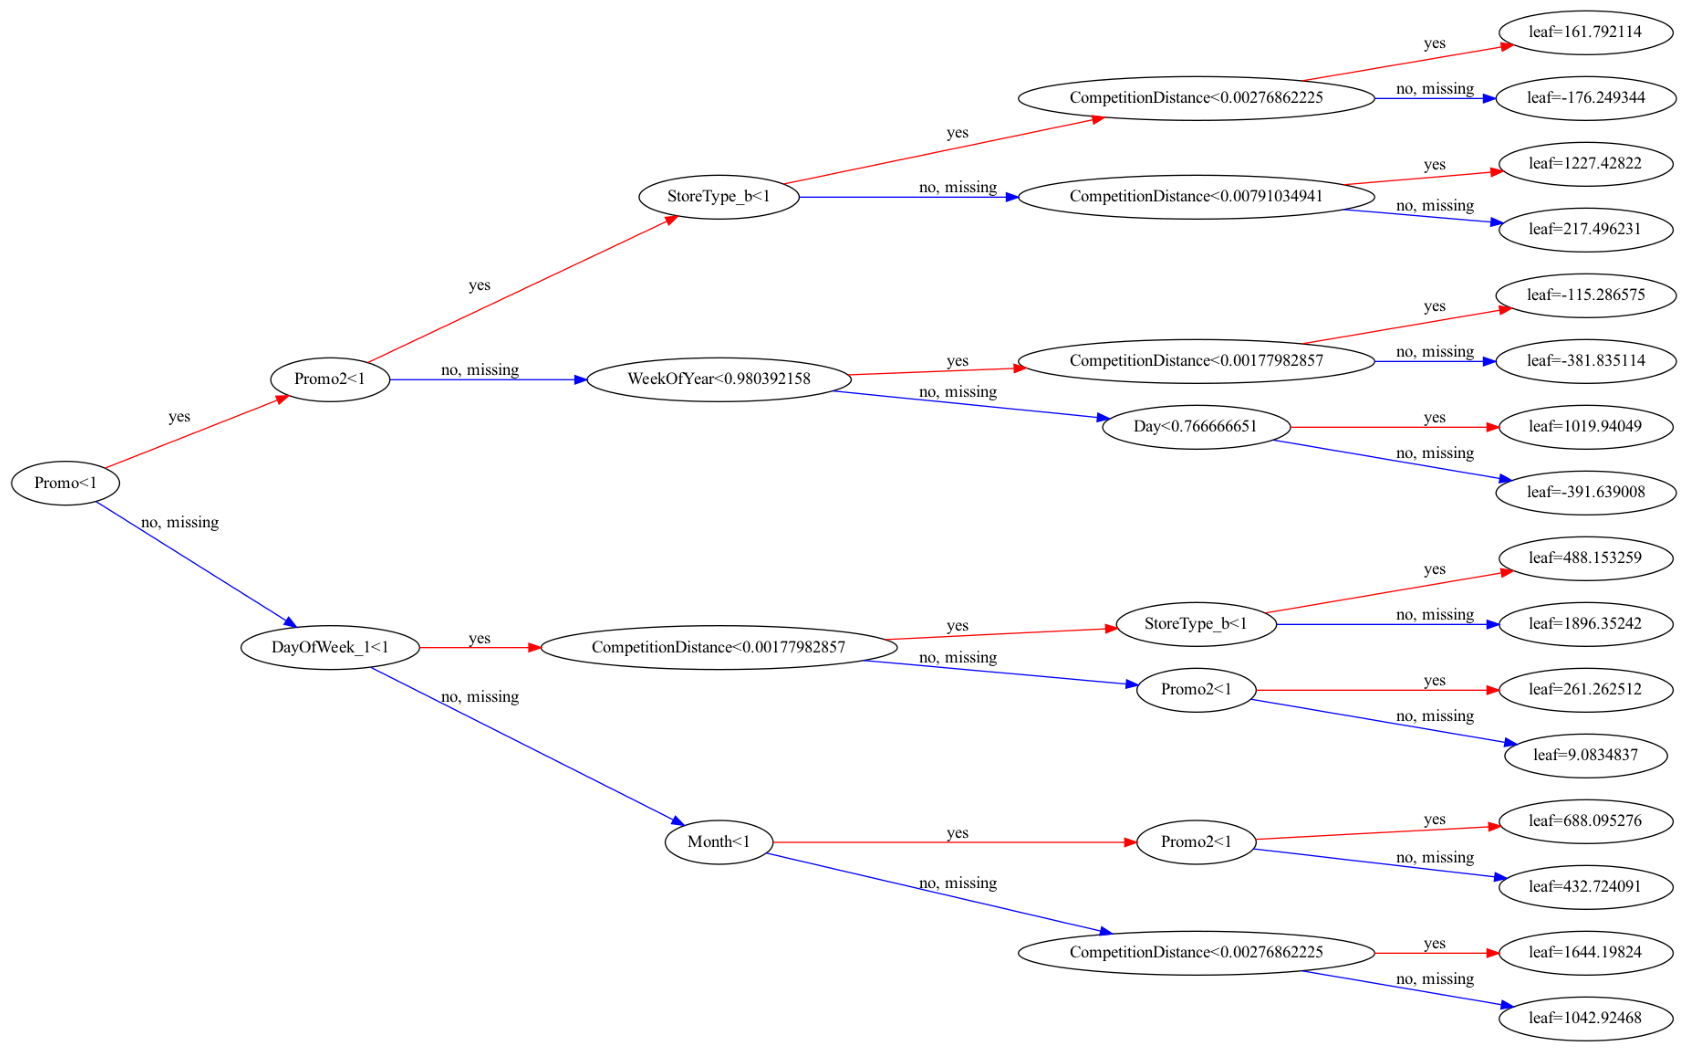

In [91]:
plot_tree(model, rankdir='LR', num_trees=1 ) #LR is left to right

<AxesSubplot:>

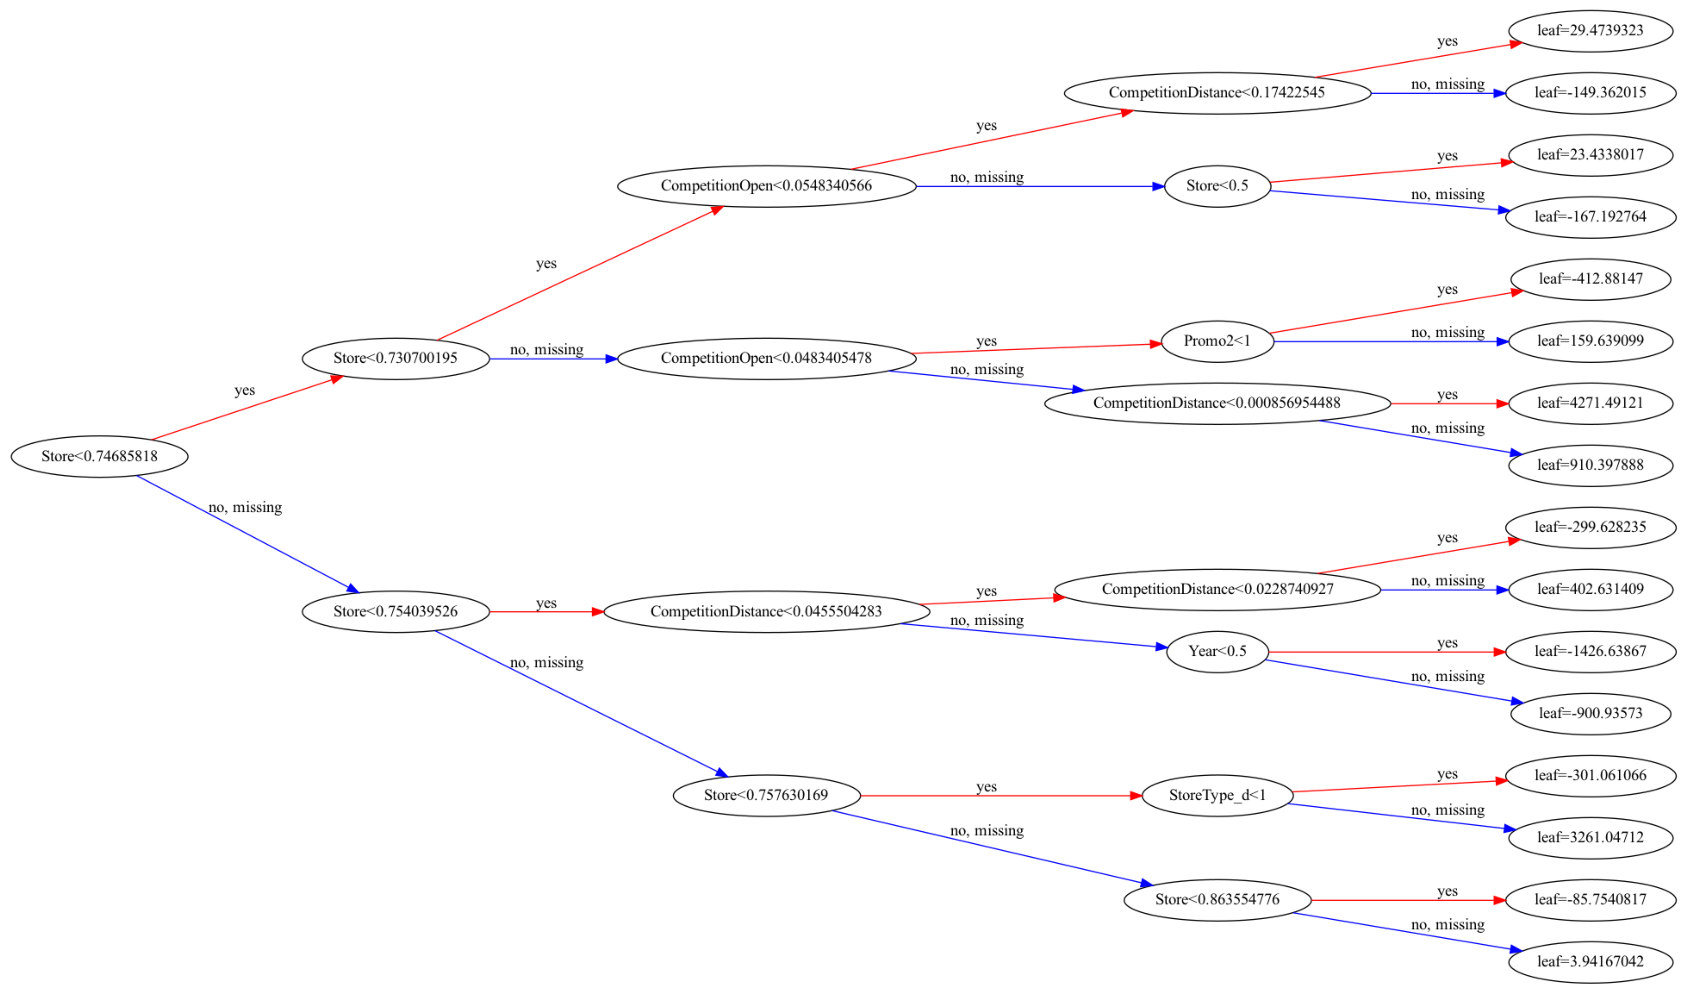

In [94]:
plot_tree(model, rankdir='LR', num_trees=19 ) #LR is left to right

### Note: 
Notice how the trees only compute residuals, and not the actual target value. We can also visualize the tree as text.

In [96]:
trees = model.get_booster().get_dump()

In [99]:
print(trees[0])

0:[Promo<1] yes=1,no=2,missing=2
	1:[StoreType_b<1] yes=3,no=4,missing=4
		3:[Assortment_a<1] yes=7,no=8,missing=8
			7:[CompetitionDistance<0.0023071852] yes=15,no=16,missing=16
				15:leaf=181.975769
				16:leaf=-259.831238
			8:[WeekOfYear<0.921568632] yes=17,no=18,missing=18
				17:leaf=-467.055237
				18:leaf=-83.930191
		4:[CompetitionDistance<0.00791034941] yes=9,no=10,missing=10
			9:[CompetitionDistance<0.00593276182] yes=19,no=20,missing=20
				19:leaf=654.354065
				20:leaf=3492.14575
			10:[DayOfWeek_7<1] yes=21,no=22,missing=22
				21:leaf=-187.357132
				22:leaf=877.194702
	2:[DayOfWeek_1<1] yes=5,no=6,missing=6
		5:[Month<1] yes=11,no=12,missing=12
			11:[StoreType_b<1] yes=23,no=24,missing=24
				23:leaf=208.808884
				24:leaf=1208.23828
			12:[Day<0.200000003] yes=25,no=26,missing=26
				25:leaf=668.335449
				26:leaf=1160.14038
		6:[Month<1] yes=13,no=14,missing=14
			13:[CompetitionDistance<0.00138431112] yes=27,no=28,missing=28
				27:leaf=1261.60889
				28:leaf=752

### Feature importance

Just like decision trees and random forests, XGBoost also provides a feature importance score for each column in the input.


Feature important score is calculated in different ways like number of splits and gain. The number of splits determines the complexity of individual decision trees, while gain guides the construction of these trees by selecting the most informative splits at each node. These aspects are important considerations in gradient boosting to ensure that the ensemble model achieves optimal predictive performance while avoiding overfitting.

In [101]:
importance_df=pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance',ascending=False)

In [102]:
importance_df.head(10)

,feature,importance
1,Promo,0.309244
12,DayOfWeek_1,0.076455
26,StoreType_d,0.071732
24,StoreType_b,0.066487
5,Promo2,0.040490
3,CompetitionDistance,0.039816
27,Assortment_a,0.038316
25,StoreType_c,0.036829
4,CompetitionOpen,0.034157
9,Month,0.026813


/var/folders/vd/7kcv0wsd01qflzy6p6wd496h0000gn/T/ipykernel_80194/2182863399.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df.head(10), x='importance', y='feature', palette='husl')


<AxesSubplot:title={'center':'Feature Importance'}, xlabel='importance', ylabel='feature'>

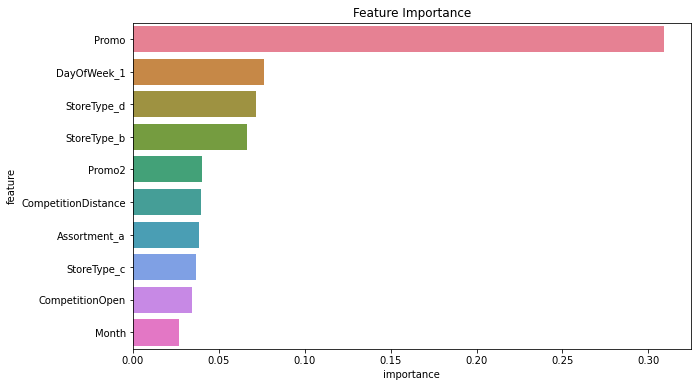

In [105]:
import seaborn as sns
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature', palette='husl')

In [106]:
jovian.commit()

<IPython.core.display.Javascript object>

[jovian] Updating notebook "pragyakiran03041996/lesson5" on https://jovian.com/
[jovian] Committed successfully! https://jovian.com/pragyakiran03041996/lesson5


'https://jovian.com/pragyakiran03041996/lesson5'

## K Fold Cross Validation

Notice that we didn't create a validation set before training our XGBoost model. We'll use a different validation strategy this time, called K-fold cross validation ([source](https://vitalflux.com/k-fold-cross-validation-python-example/)):

![](https://vitalflux.com/wp-content/uploads/2020/08/Screenshot-2020-08-15-at-11.13.53-AM.png)

Note: K-fold cross validation is not a good choice here. Because validation set should be closer to test sets, here with the date example we will have test set which will predict sales for the future, so we should have validation set for years, later to which the model has been trained for.

And its not effective for large datasets with millions of rows as you will require more computational resources

In [108]:
from sklearn.model_selection import KFold

Let's define a helper function `train_and_evaluate` which trains a model the given parameters and returns the trained model, training error and validation error.

In [114]:
def train_and_evaluate(X_train, train_targets, X_val, val_targets, **params):
    model = XGBRegressor(random_state=42, n_jobs=-1, **params)
    model.fit(X_train, train_targets)
    train_rmse = rmse(model.predict(X_train), train_targets)
    val_rmse = rmse(model.predict(X_val), val_targets)
    return model, train_rmse, val_rmse

Now, we can use the `KFold` utility to create the different training/validations splits and train a separate model for each fold.

In [110]:
kfold = KFold(n_splits=5)

In [116]:
models = []
for train_idxs, val_idxs in kfold.split(X):
    X_train, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs]
    X_val, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]
    
    model, train_rmse, val_rmse = train_and_evaluate(X_train, train_targets, 
                                                    X_val, val_targets,
                                                    max_depth=4, n_estimators=20)
    
    models.append(model)
    print('Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))


/Users/pragya/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pragya/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Train RMSE: 2370.7136430479463, Validation RMSE: 2448.739998478758


/Users/pragya/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pragya/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Train RMSE: 2376.830658491627, Validation RMSE: 2413.5622536102155


/Users/pragya/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pragya/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Train RMSE: 2386.944071778845, Validation RMSE: 2364.856120007352


/Users/pragya/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pragya/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Train RMSE: 2348.3401652445446, Validation RMSE: 2458.1552579968957
Train RMSE: 2370.9691440768092, Validation RMSE: 2441.7500928714353


/Users/pragya/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pragya/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Let's also define a function to average predictions from the 5 different models.

In [117]:
import numpy as np

In [118]:
models

[XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=20, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...),
 XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metri

In [121]:
def predict_avg(model, inputs):
    return np.mean([model.predict(inputs) for model in models], axis = 0)

In [123]:
preds = predict_avg(models, X)
preds

array([8013.9463, 7508.8916, 8623.156 , ..., 7844.056 , 7589.815 ,
       9704.449 ], dtype=float32)

In [124]:
train_targets

0          5263
1          6064
2          8314
3         13995
4          4822
          ...  
811963     6848
811964     4513
811965     5749
811966    10201
811967    15589
Name: Sales, Length: 675514, dtype: int64

## Hyperparameter Tuning and Regularization

Just like other machine learning models, there are several hyperparameters we can to adjust the capacity of model and reduce overfitting.

<img src="https://i.imgur.com/EJCrSZw.png" width="480">

Check out the following resources to learn more about hyperparameter supported by XGBoost:

- https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor
- https://xgboost.readthedocs.io/en/latest/parameter.html

In [125]:
jovian.commit()

<IPython.core.display.Javascript object>

[jovian] Updating notebook "pragyakiran03041996/lesson5" on https://jovian.com/
[jovian] Committed successfully! https://jovian.com/pragyakiran03041996/lesson5


'https://jovian.com/pragyakiran03041996/lesson5'

In [126]:
from sklearn.model_selection import train_test_split

In [128]:
X_train, X_val, train_targets, val_targets = train_test_split(X, targets, test_size=0.1)

In [129]:
def test_params_kfold(n_splits, **params):
    train_rmses, val_rmses, modeds = [], [], []
    kfold = KFold(n_splits)
    
    for train_idxs, val_indxs in kfold.split(X):
        X_train, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs]
        X_val, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]
        
        model, train_rmse, val_rmse = train_and_evaluate(X_train, train_targets, X_val, val_targets, **params)
        models.append(model)
        train_rmses.append(train_rmse)
        val_rmses.append(val_rmse)
        
    print('Train RMSE: {}, Validation RMSE: {}'.format(np.mean(train_rmses), np.mean(val_rmses)))
    return models

Since it may take a long time to perform 5-fold cross validation for each set of parameters we wish to try, we'll just pick a random 10% sample of the dataset as the validation set.

In [132]:
def test_params(**params):
    model = XGBRegressor(n_jobs=-1, random_state=42, **params)
    model.fit(X_train, train_targets)
    train_rmse = rmse(model.predict(X_train), train_targets)
    val_rmse = rmse(model.predict(X_val), val_targets)
    
    print('Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))
    

#### `n_estimators`

The number of trees to be created. More trees = greater capacity of the model.

In [133]:
test_params(n_estimators=20)

Train RMSE: 2018.4699692675558, Validation RMSE: 2025.8084534597126


/Users/pragya/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pragya/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [136]:
test_params(n_estimators=100)

Train RMSE: 1158.6991580457993, Validation RMSE: 1169.3987913413982


/Users/pragya/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pragya/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [139]:
test_params(n_estimators=200)

Train RMSE: 935.7715573055088, Validation RMSE: 948.3267653057184


/Users/pragya/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pragya/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


#### `max_depth`

As you increase the max depth of each tree, the capacity of the tree increases and it can capture more information about the training set.

In [142]:
test_params(n_estimators=200, max_depth=10)

Train RMSE: 553.8813064168495, Validation RMSE: 699.4673648901089


/Users/pragya/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pragya/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [143]:
test_params(n_estimators=200, max_depth=12) 

Train RMSE: 401.52840483662385, Validation RMSE: 709.6707480531448


/Users/pragya/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pragya/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


SO, in the above example, with max_depth=12, we are going into overfitting region, as the training error is getting smaller whereas validation error is getting larger


#### `learning_rate`

The scaling factor to be applied to the prediction of each tree. A very high learning rate (close to 1) will lead to overfitting, and a low learning rate (close to 0) will lead to underfitting.

In [144]:
test_params(n_estimators=200, max_depth=10, learning_rate=0.1) 

Train RMSE: 723.033918441575, Validation RMSE: 794.9161321504321


/Users/pragya/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pragya/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [149]:
test_params(n_estimators=200, max_depth=12, learning_rate=0.2) 

Train RMSE: 454.23754209709443, Validation RMSE: 696.1345388044163


/Users/pragya/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/pragya/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


#### `booster`

Instead of using Decision Trees, XGBoost can also train a linear model for each iteration. This can be configured using `booster`.

In [154]:
test_params(booster='gblinear')

Train RMSE: 2726.9516671790684, Validation RMSE: 2730.4302771796483


Clearly, a linear model is not well suited for this dataset


In [157]:
jovian.commit()

<IPython.core.display.Javascript object>

[jovian] Updating notebook "pragyakiran03041996/lesson5" on https://jovian.com/
[jovian] Committed successfully! https://jovian.com/pragyakiran03041996/lesson5


'https://jovian.com/pragyakiran03041996/lesson5'

## Putting it Together and Making Predictions

Let's train a final model on the entire training set with custom hyperparameters. 

In [158]:
model = XGBRegressor(n_jobs=-1, random_state=42, n_estimators=1000, 
                     learning_rate=0.2, max_depth=10, subsample=0.9,
                    colsample_bytree=0.7)

# colsample_bytree --> use only certain columns for a decison tree
# subsample --> take only a fraction of rows

In [201]:
%%time
model.fit(X,targets)

CPU times: user 2min 22s, sys: 46.3 s, total: 3min 8s
Wall time: 24.5 s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [160]:
train_preds = model.predict(X)
rmse(train_preds, targets)

380.3540729701204

In [164]:
test_preds = model.predict(X_test)

In [165]:
test_preds

array([ 4194.3403,  8461.7   ,  9530.487 , ...,  6030.6343, 23649.21  ,
        6598.839 ], dtype=float32)

Let's add the predictions into `submission_df`.

In [166]:
submission_df['Sales'] = test_preds

Recall, however, if if the store is not open, then the sales must be 0. Thus, wherever the value of `Open` in the test set is 0, we can set the sales to 0. Also, there some missing values for `Open` in the test set. We'll replace them with 1 (open).

In [168]:
test_df.Open.isna().sum()

11

In [173]:
test_df.Open.unique()

array([ 1., nan,  0.])

In [191]:
submission_df['Sales'] = submission_df['Sales'] * test_df.Open.fillna(1.)

In [193]:
submission_df

,Id,Sales
0,1,4194.340332
1,2,8461.700195
2,3,9530.487305
3,4,7161.187988
4,5,7427.832031
...,...,...
41083,41084,2611.566406
41084,41085,6606.491211
41085,41086,6030.634277
41086,41087,23649.210938


We can now save the predictions as a CSV file.


In [198]:
submission_df.to_csv('submission.csv', index=None)

In [196]:
from IPython.display import FileLink

In [199]:
FileLink('submission.csv')

/Users/pragya/Desktop/LEARN/ML_freecode/submission.csv

We can now make a submission on this page and check our score: https://www.kaggle.com/c/rossmann-store-sales/submit



In [202]:
jovian.commit()

<IPython.core.display.Javascript object>

[jovian] Updating notebook "pragyakiran03041996/lesson5" on https://jovian.com/
[jovian] Committed successfully! https://jovian.com/pragyakiran03041996/lesson5


'https://jovian.com/pragyakiran03041996/lesson5'

## Revision

1. A Gradient Boosting Machine (GBM) model is a machine learning technique that sequentially combines multiple weak learners (typically decision trees) to create a strong predictive model.
2. In the term 'gradient', it refers to the optimization process where the algorithm minimizes the loss function by moving in the direction of steepest descent.
3. 'Boosting' refers to the process of sequentially improving the model by focusing on the mistakes made by the previous models in the ensemble.
4. Weights and bias are parameters in machine learning models. Weights adjust the importance of input features, while bias adjusts the prediction regardless of input.
5. Numerical columns contain continuous data, while categorical columns contain discrete data. Different techniques such as one-hot encoding or label encoding are used for handling categorical columns.
6. Scaling numerical columns ensures that all features have the same scale, preventing some features from dominating others during training.
7. Encoding categorical columns converts categorical data into numerical form, which can be processed by machine learning algorithms.
8. In `plot_tree()`, `rankdir` determines the orientation of the tree visualization (e.g., horizontal or vertical).
9. K-fold cross-validation divides the dataset into k subsets and iteratively uses each subset as a validation set while training the model on the remaining data.
10. The gamma hyperparameter controls the complexity of the decision boundary in SVM models. It represents the influence of a single training example on the decision boundary. (not learned rn)
11. Generalization refers to a model's ability to perform well on unseen data, indicating that it has learned underlying patterns rather than memorizing the training data.
12. Ensembling combines multiple models to improve predictive performance by leveraging the strengths of each individual model.
13. Different ways to impute missing data include mean or median imputation, interpolation, or using machine learning algorithms to predict missing values.
14. Advantages of XGBoost include scalability, handling of missing values, regularization, and high predictive accuracy.
15. Disadvantages of XGBoost include potential overfitting, sensitivity to hyperparameters, and longer training times compared to simpler models.
16. Data preprocessing steps for XGBoost include handling missing values, encoding categorical variables, scaling numerical features, and splitting the data into training and testing sets.
17. `rcParams` is a dictionary-like object in Matplotlib that stores default configurations for plot settings.
18. `get_dump()` in XGBoost returns the textual representation of the trees in the model.
19. XGBoost and LightGBM are both gradient boosting frameworks, but they differ in their implementation details and performance characteristics.
20. XGBoost is generally faster than Random Forest due to its optimization techniques such as parallel processing, tree pruning, and cache optimization.

In [203]:
jovian.commit()

<IPython.core.display.Javascript object>

[jovian] Updating notebook "pragyakiran03041996/lesson5" on https://jovian.com/
[jovian] Committed successfully! https://jovian.com/pragyakiran03041996/lesson5


'https://jovian.com/pragyakiran03041996/lesson5'